<a href="https://colab.research.google.com/github/alessiapontiggia/progetto-LABIAGI---Breast-Cancer-Classifier-and-Detection/blob/main/breast_cancer_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breast Cancer Classifier: Machine Learning

Nella seguente pagina si vuole mostrare il lavoro di un classificatore di Machine Learning applicato in ambito medico, in particolare si vuole implementare un predittore capace di capire se un paziente ha il cancro al seno oppure no, a partire da un certo insieme di dati.

# Introduzione


Secondo i dati riportati nel report "*I numeri del cancro in Italia 2020*" a cura tra gli altri dell’Associazione italiana registri tumori (AIRTUM) e l’Associazione italiana di oncologia medica (AIOM), il tumore della mammella resta la neoplasia più frequente in Italia.

Con 54.976 nuove diagnosi in un anno, questo tumore rappresenta infatti il 30,3 per cento di tutti i tumori che colpiscono le donne e il 14,6 per cento di tutti i tumori diagnosticati in Italia.

Tuttavia, se l’incidenza (numero di nuovi casi) è in leggera crescita soprattutto nelle donne più giovani, la mortalità è in diminuzione (una riduzione del 6 per cento nel 2020 rispetto al 2015), pur rimanendo questa malattia la prima causa di morte per tumore nelle donne.

Il dataset di partenza è ripreso dal sito ufficiale UCI, https://archive.ics.uci.edu/ml/datasets.php , 
che contiene dataset (reali e non) per applicazioni di Machine Learning.


Importiamo le librerie esterne necessarie:

In [1]:
import warnings 
warnings.filterwarnings('ignore')

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import itertools
import numpy as np
import math

Vediamo nel dettaglio l'insieme su cui lavoriamo:

In [3]:
# leggiamo il file in input
dataset = pd.read_csv("/content/cancer_dataset.csv")
# splittiamo i dati in training e test set
X_train, X_test, Y_train, Y_test = train_test_split(dataset[['Age', 'BMI', 'Glucose', 'Insulin', 'HOMA', 'Leptin', 'Adiponectin', 'Resistin', 'MCP.1']], dataset[['Classification']], test_size=0.2)


In [4]:
dataset

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1,Classification
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114,0
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,0
2,82,23.124670,91,4.498,1.009651,17.9393,22.432040,9.27715,554.697,0
3,68,21.367521,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220,0
4,86,21.111111,92,3.549,0.805386,6.6994,4.819240,10.57635,773.920,0
...,...,...,...,...,...,...,...,...,...,...
111,45,26.850000,92,3.330,0.755688,54.6800,12.100000,10.96000,268.230,1
112,62,26.840000,100,4.530,1.117400,12.4500,21.420000,7.32000,330.160,1
113,65,32.050000,97,5.730,1.370998,61.4800,22.540000,10.33000,314.050,1
114,72,25.590000,82,2.820,0.570392,24.9600,33.750000,3.27000,392.460,1


Le features si dividono in:


*   *Variabili indipendenti*: chiamate anche inputs, non dipendono da altre features

*   *Variabili dipendenti*: chiamate anche outputs, dipendono dalle variabili indipendenti. 

Le features indipendenti (X) su cui lavoriamo in questo dataset sono:


*   **Età** (espressa in anni) del paziente
*   **BMI** (indice di massa corporea) = peso(kg)/altezza(m)^2
*   **Glocosio** che esprime il livello ematico degli zuccheri
*   **Insulina**  
*  **HOMA** indica la sensibilità dell'insulina
*   **Leptina**
*   **Adiponectina**
*   **Resistina**
*   **MCP.1**

La feature dipendente (Y) è:

*   **Classificazione**, che assume i valori:
    - 0: il paziente ***non*** è malato
    - 1: il paziente è malato


# Analisi dei dati


Per prima cosa controlliamo che il dataset sia privo di valori non validi (NaN values). 

In [ ]:
dataset.isna().sum()

Age               0
BMI               0
Glucose           0
Insulin           0
HOMA              0
Leptin            0
Adiponectin       0
Resistin          0
MCP.1             0
Classification    0
dtype: int64

Come visto sopra, il dataset non contiene tali valori. Possiamo procedere con l'analisi.


Vediamo ora, nei grafici sotto riportati, le relazioni tra i dati:

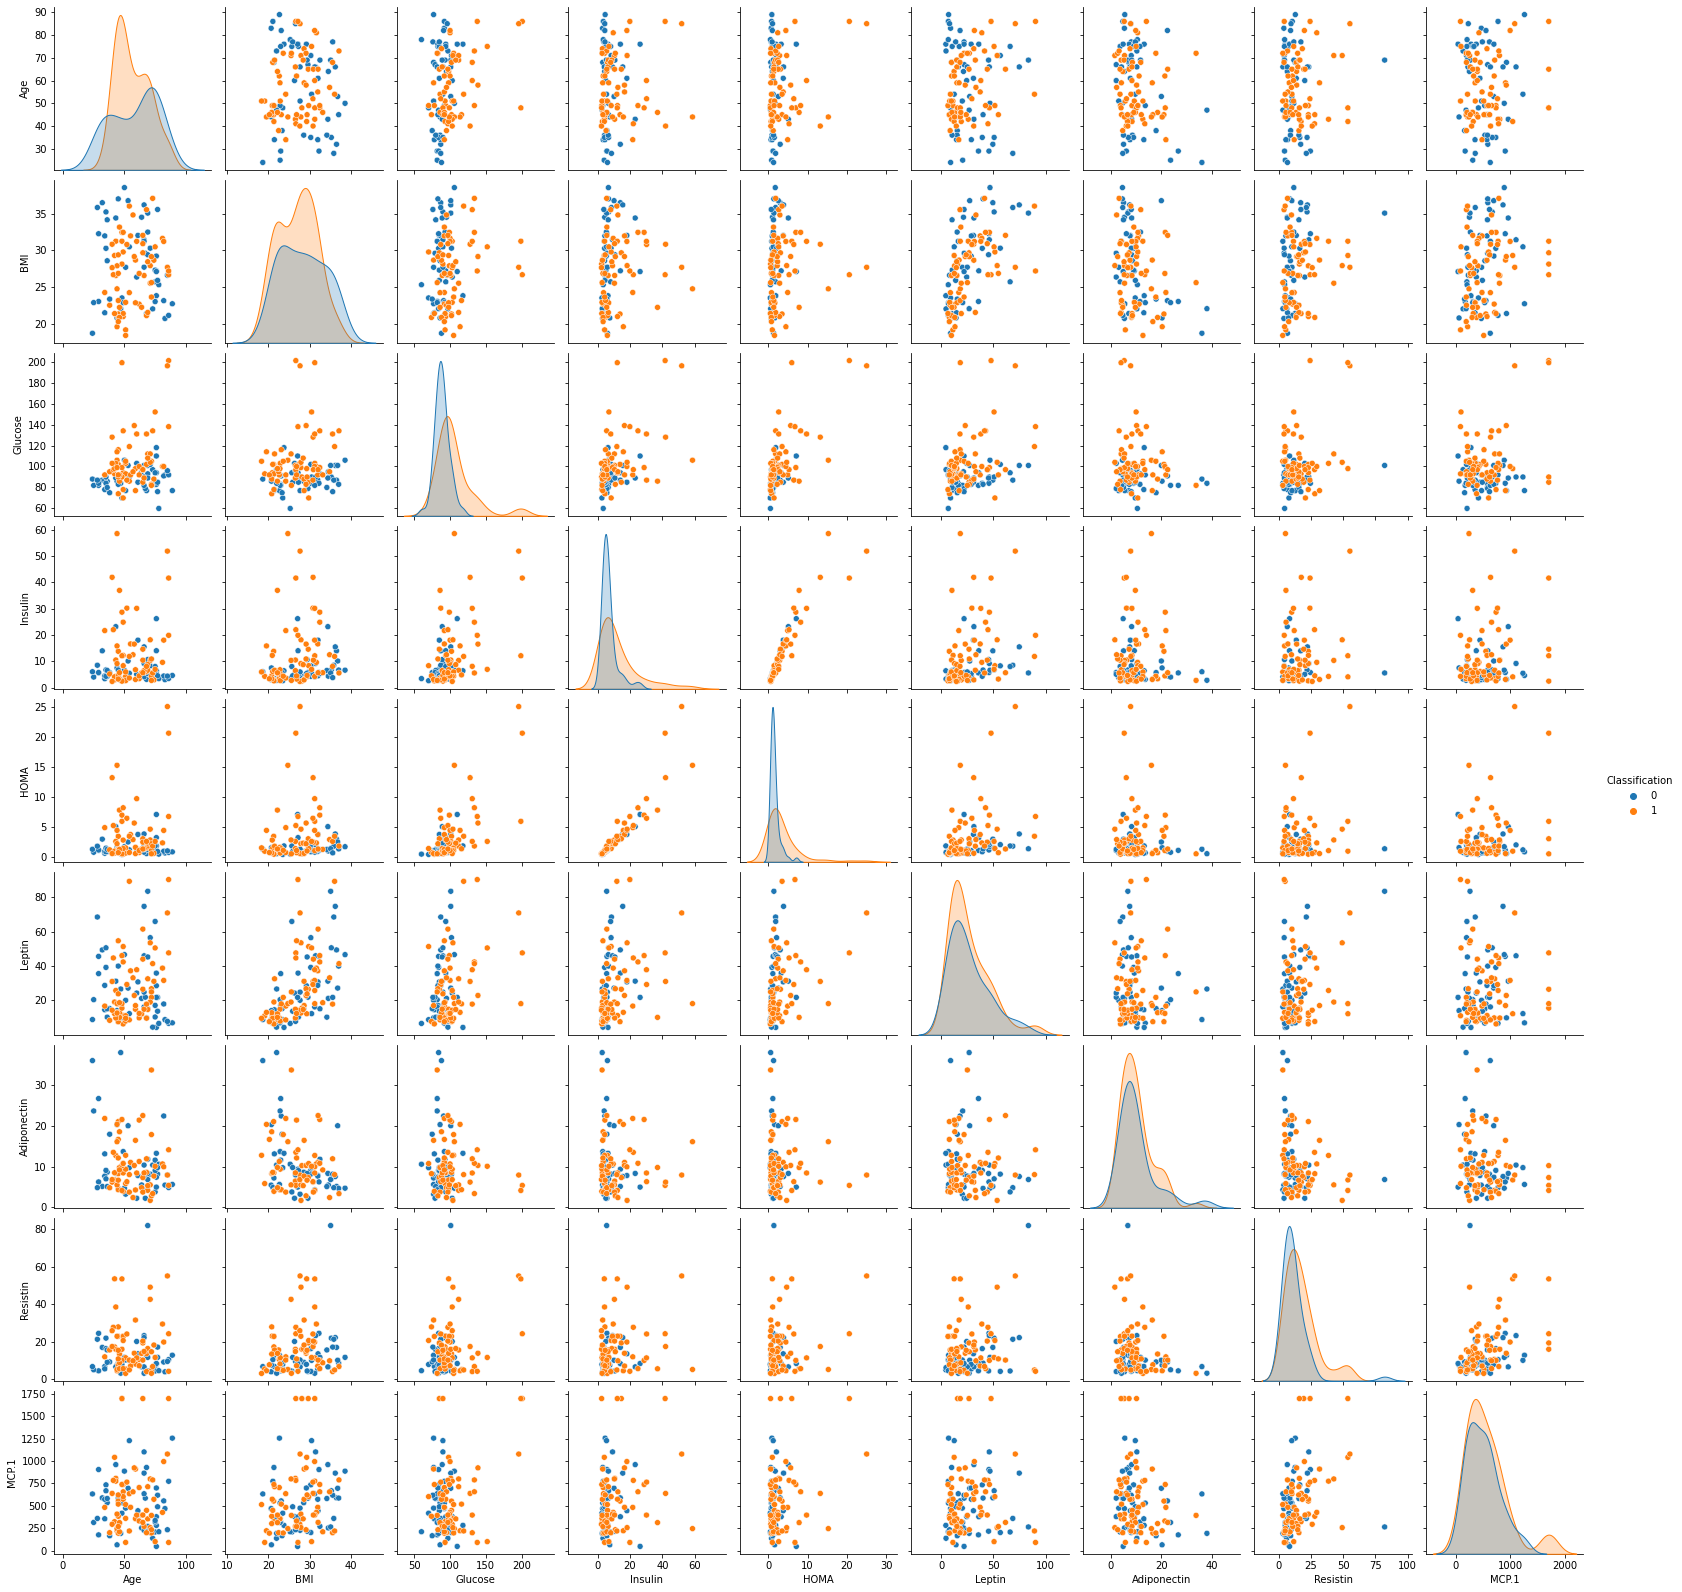

In [ ]:
sns.pairplot(dataset, hue='Classification', size=2.5)


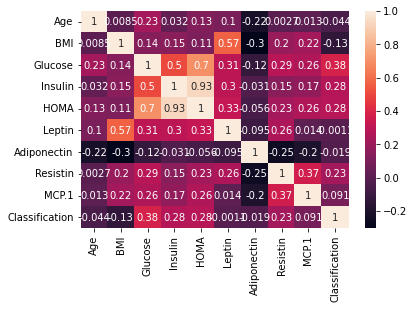

In [ ]:
sns.heatmap(dataset.corr(), annot=True)

# Divisione in training e test set

La prima cosa di cui ci occupiamo è la **suddivisione del dataset** in *training* e *test set*.

Questo è necessario perché nell'apprendimento supervisionato, sfera di ML su cui ci concentriamo in questo paper, è possibile che si verifichino due fenomeni, che vogliamo evitare, **underfitting** o **overfitting**.

Nel primo caso, *underfitting*, il modello ottiene scarse performance su training e test set. Mentre con *overfitting* si hanno buoni risultati sul training set, ma scarsi sul test set.

Il nostro obiettivo è una buona generalizzazione del modello, cioè vogliamo che l'algoritmo ottenga buone prestazioni su insiemi di dati che non ha mai visto. 

La divisione del dataset in training e test set ci permette, quindi, di capire se questi due fenomeni avvengono.

Di seguito il **training set** delle sole features (X) su cui addestreremo l'algoritmo; ricordiamo che la funzione di split di sklearn divide il dataset in modo casuale, rafforzando quindi l'idea per cui le osservazioni che compongono l'insieme sono indipendenti l'una dalle altre.


In [5]:
X_train

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1
29,36,34.174890,80,6.590,1.300427,10.2809,5.065915,15.72187,581.313
83,71,25.510204,112,10.395,2.871792,19.0653,5.486100,42.74470,799.898
70,45,20.260000,92,3.440,0.780651,7.6500,16.670000,7.84000,193.870
44,71,30.300000,102,8.340,2.098344,56.5020,8.130000,4.29890,200.976
53,45,20.829995,74,4.560,0.832352,7.7529,8.237405,28.03230,382.955
...,...,...,...,...,...,...,...,...,...
5,49,22.854458,92,3.226,0.732087,6.8317,13.679750,10.31760,530.410
3,68,21.367521,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220
102,65,30.915577,97,10.491,2.510147,44.0217,3.710090,20.46850,396.648
59,62,22.656250,92,3.482,0.790182,9.8648,11.236235,10.69548,703.973


I target associati a queste observations sono:

In [6]:
Y_train 

,Classification
29,0
83,1
70,1
44,0
53,1
...,...
5,0
3,0
102,1
59,1


Di seguito il **test set** su cui testeremo l'algoritmo: 

In [7]:
X_test

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1
82,48,32.461911,99,28.677,7.002923,46.0760,21.570000,10.15726,738.034
88,48,31.250000,199,12.162,5.969920,18.1314,4.104105,53.63080,1698.440
63,51,22.892820,103,2.740,0.696143,8.0163,9.349775,11.55492,359.232
34,51,27.688778,77,3.855,0.732193,20.0920,3.192090,10.37518,473.859
78,86,26.666667,201,41.611,20.630734,47.6470,5.357135,24.37010,1698.440
57,68,21.082813,102,6.200,1.559920,9.6994,8.574655,13.74244,448.799
16,47,22.030000,84,2.869,0.590000,26.6500,38.040000,3.32000,191.720
64,59,22.832879,98,6.862,1.658774,14.9037,4.230105,8.20490,355.310
106,45,29.384757,90,4.713,1.046286,23.8479,6.644245,15.55625,621.273
80,59,28.672626,77,3.188,0.605507,17.0220,16.440480,31.69040,910.489


In [8]:
Y_test

,Classification
82,1
88,1
63,1
34,0
78,1
57,1
16,0
64,1
106,1
80,1



> Preprocessamento dei dati


Per evitare distorsione negli intervalli di valori, standardizziamo i dati.


La standardizzazione è una tecnica di preprocessamento dei dati consiste nel sottrarre la media (μ) da ogni valore (x) del vettore e dividere la differenza per la devianza standard (σ).

In [9]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

Ora concentriamoci sui modelli da testare e, quindi, sui classificatori che vogliamo implementare.

# Logistic Regression - modulo sklearn

Il predittore che analizzeremo utilizza la **logistic regression** ovvero una *tecnica di classificazione* semplice, utilizzata in ambito medico proprio per la sua facile interpretazione.


> La classificazione è un'area dell'apprendimento supervisionato che prova a predirre a quale classe o categoria appartiene una certa entità, a partire dalle sue features.



Ora chiamiamo dalla libreria sklearn la funzione LogisticRegression().

In [10]:
model = LogisticRegression()
lr = model.fit(X_train, Y_train)
predictions = model.predict(X_test)

# Valutare la performance

Come capiamo se il modello ha avuto successo? Vedremo nel seguito alcune metriche che ci aiutano in questo.

Innanzitutto, procediamo con delle notazioni. 
Indichiamo con:

*   **TP**: Numero di veri positivi (classificati true erano true).
*   **TN**: Numero di veri negativi (classificati false erano false).
*   **FP**: Numero di falsi positivi (classificati true anche se false).
*   **FN**: Numero di falsi negativi (classificati false anche se true).

Di seguito alcune delle più importanti metriche:

1.   **Accuracy**: percentuale di classificazioni corrette, dato da (TP+TN)/(TP+TN+FN+FP).



In [11]:
train_score = model.score(X_train, Y_train)
test_score = model.score(X_test, Y_test)
print("Accuracy of training: "+str(train_score)+"\nAccuracy of test: "+str(test_score))

Accuracy of training: 0.782608695652174
Accuracy of test: 0.75



2.  **Confusion Matrix**: in una matrice 2x2 si riportano i TP, TF, FP, FN. 



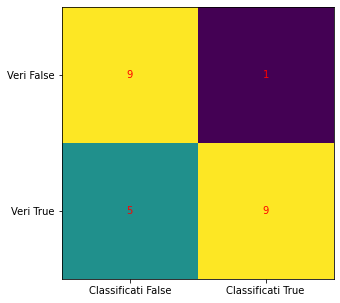

In [12]:
cm = confusion_matrix(Y_test, model.predict(X_test))
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Classificati False', 'Classificati True'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Veri False', 'Veri True'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [13]:
TP=cm[0][0]
TN=cm[1][1]
FP=cm[0][1]
FN=cm[1][0]

print("Come abbiamo visto precedentemente l'accuracy del modello è", (TP+TN)/(TP+TN+FN+FP))


Come abbiamo visto precedentemente l'accuracy del modello è 0.75


3.   **Precision**: percentuale di positivi trovati, dato da TP/TP+FP.
4.   **Recall**: misura la sensibilità del modello, dato da TP/TP+FN.
5. **F1-score**: misura l'accuratezza di un test, dato da 2*(precision * recall)/(precision+recall)

In [14]:
print(classification_report(Y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.64      0.90      0.75        10
           1       0.90      0.64      0.75        14

    accuracy                           0.75        24
   macro avg       0.77      0.77      0.75        24
weighted avg       0.79      0.75      0.75        24



**Precision-Recall Curve**

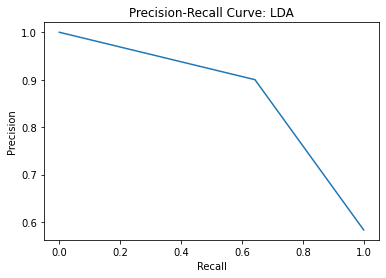

f1-score:  0.75


In [15]:
# precision-recall curve

precision, recall, thresholds = precision_recall_curve(Y_test, predictions)
plt.figure()
plt.plot(recall, precision)
plt.title("Precision-Recall Curve: LDA")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

print ("f1-score: ", f1_score(Y_test, predictions))

**ROC Curve**


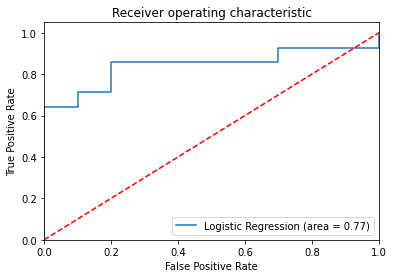

In [16]:
logit_roc_auc = roc_auc_score(Y_test, predictions)
fpr, tpr, thresholds = roc_curve(Y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Migliorare la performance

*Possiamo fare meglio ?*

Esistono vari modi per migliorare il nostro modello.



Vediamo un primo approccio che consiste nella **features selection**; si tratta di un metodo che vuole escludere dall'apprendimento del modello le features considerate "*irrilevanti*" e quindi considerare quelle che hanno più *importanza*. 

La features selection ha, inoltre, l'obiettivo di rendere il modello meno complesso poiché si riduce il numero di features. Questo è molto utile perché con l'aumentare della complessità del modello si ha più probabilità di overfittare il modello stesso.

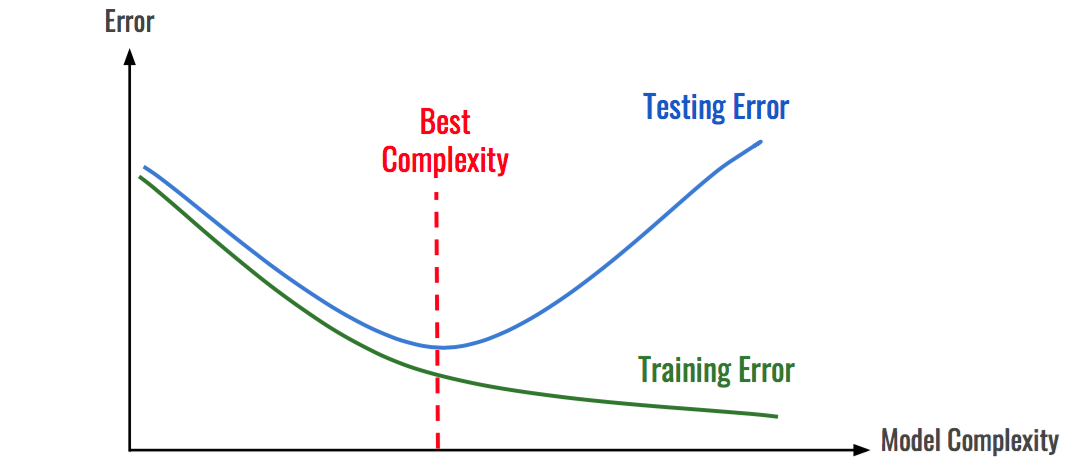


Le categorie sotto cui vengono raggruppate le tecniche di features selection sono:


1.   **Filter methods**
2.   **Wrapper methods**
3.   **Embedded methods**
4.   **Hybrid methods**


Per la prima categoria *filter methods*, scegliamo la tecnica **information gain**.


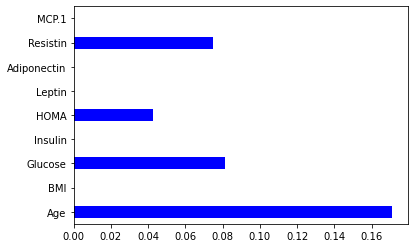

In [17]:
importance = mutual_info_classif(X_train, Y_train)
feat_import = pd.Series(importance, dataset.columns[:-1])
feat_import.plot(kind="barh", color="b")
plt.show()

In [18]:
X_train_df = pd.DataFrame(X_train)
X_train_IG = X_train_df[[0,2,5,7]]  # indici delle features con maggiore information gain

X_test_df = pd.DataFrame(X_test)
X_test_IG = X_test_df[[0,2,5,7]]

model = LogisticRegression()
model.fit(X_train_IG, Y_train)
train_score = model.score(X_train_IG, Y_train)
test_score_IG = model.score(X_test_IG, Y_test)
print("Accuracy of training: "+str(train_score)+"\nAccuracy of test: "+str(test_score_IG))


Accuracy of training: 0.75
Accuracy of test: 0.75


Per la seconda categoria *wrapper methods*, scegliamo la tecnica **recursive feature elimination (RFE)**.

In [19]:
number_of_features = len(list(dataset.columns))-1
start = 0
end = number_of_features
model = LogisticRegression()
d = {}
while end>0:
  rfe = RFE(model, n_features_to_select=end)
  rfe.fit(X_train, Y_train)
  pred = rfe.predict(X_test)
  value = list(rfe.get_support(indices=True))
  d[rfe.score(X_test, Y_test)] = value
  start = start+1
  end = end-1


In [20]:
best_score_RFE=0
for key in d.keys():
  if key>best_score_RFE:
    best_score_RFE=key

features = list(dataset.columns[:-1])
selected_features = []

for index in d[best_score_RFE]:
  selected_features.append(features[index])


print("Dopo aver operato la RFE sul nostro dataset, abbiamo raggiunto una performance con accuracy pari a", best_score_RFE)
print("\nLe features selezionate che hanno contribuito a questo risultato sono", selected_features)

Dopo aver operato la RFE sul nostro dataset, abbiamo raggiunto una performance con accuracy pari a 0.7916666666666666

Le features selezionate che hanno contribuito a questo risultato sono ['BMI', 'Glucose', 'Insulin', 'Leptin', 'Resistin']


Ora vediamo la tecnica **random forest importance** appartenente alla terza categoria, *embedded methods*.

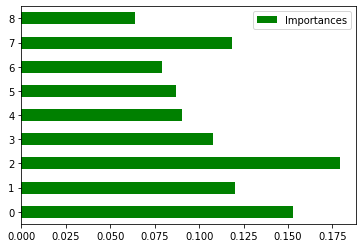

In [21]:
model = RandomForestClassifier()
model.fit(X_train,Y_train)

imp = model.feature_importances_
final = pd.DataFrame({"Importances":imp})
final.set_index("Importances")
final.plot(kind="barh", color="green")


In [22]:
X_train_df = pd.DataFrame(X_train)
X_train_IG = X_train_df[[0,2,4,7]]  # indici delle features con maggiore importance

X_test_df = pd.DataFrame(X_test)
X_test_IG = X_test_df[[0,2,4,7]]

model = LogisticRegression()
model.fit(X_train_IG, Y_train)
train_score = model.score(X_train_IG, Y_train)
test_score_RFC = model.score(X_test_IG, Y_test)
print("Accuracy of training: "+str(train_score)+"\nAccuracy of test: "+str(test_score_RFC))


Accuracy of training: 0.7065217391304348
Accuracy of test: 0.75


Come vediamo dagli score ottenuti, tra le tecniche sopra riportate, quella che **aumenta l'accuracy** del nostro modello è la **recursive features elimination**.

# Logistic Regression - mia implementazione



Nel modulo sklearn non si percepiscono tutti i passaggi che la logistic regression deve fare per arrivare alla soluzione. 
Di seguito riporto tutte le fasi necessarie a capirne il funzionamento nella *mia* versione di logistic regression.



> Funzione di ipotesi


La stima **h** chiamata *ipotesi* del target, Y, è data dal prodotto tra la matrice delle features X e il vettore dei pesi W. 

Alcune precisazioni matematiche:

*   Assumendo che X sia composta da **m** osservazioni e **n** features, otteniamo una matrice mxn.   
*   Il vettore dei pesi dovrà contenere tanti elementi quante sono le features, quindi avrà dimensione nx1.
*   Il prodotto tra X e W restituirà un vettore colonna h composto da m righe, di dimensione mx1.

In [23]:
def hypothesis(X,W):
  return np.dot(X,W)


> Funzione logistica


Il target in un problema di classificazione binaria assume generalmente i valori 0,1.
Utilizziamo la funzione sigmoide, conosciuta anche come logistica, per "comprimere" il vettore ipotesi con elementi i cui valori variano tra 0 e 1.

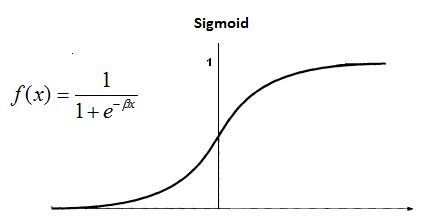

In [24]:
def sigmoid(z):
  return 1/(1+np.exp(-z))

> Funzione di costo. 

Nella regressione logistica, si preferisce utilizzare la binary cross entropy che si esprime in questo modo:

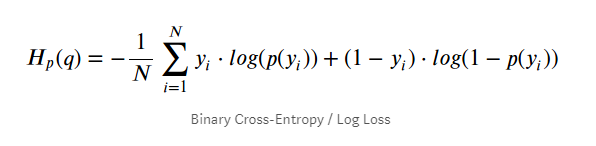

La Loss Function viene calcolata su tutto l'insieme. Poi se ne fa una media (1/N).

Possiamo notare che la prima parte della sommatoria va a 0 quando yi, cioè il target in corrispondenza dell'i-esima osservazione, è pari a 0.
Mentre il secondo termine vale 0 quando (1-yi)=0 cioè quando yi è pari a 1.


In [25]:
def cost(Y, X, W, h):
    
    n = X.shape[0]
    y = list(Y['Classification'])
    
    c = 0
    for i in range(len(y)):
      p = y[i]*math.log(h[i])+(1-y[i])*math.log(1-h[i])           # BCE
      c += p

    return c*(-1/n)



> Algoritmo completo

Ora vediamo come lavora la logistic regression con i dati che abbiamo raccolto finora.

In particolare:
* la condizione di arresto del ciclo utilizza la Binary Cross Entropy:
  se, rispetto all'iterazione precedente, la funzione di costo   diminuisce meno del fattore "eps" allora termina l'esecuzione.
* Si utilizza l'algoritmo gradient descent per l'aggiornamento dei pesi. Questo meccanismo utilizza la proprietà delle derivate per trovare il valore dei pesi che minimizza la loss.


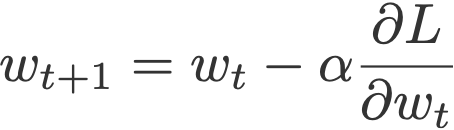

In [26]:
def logistic_regression(X, Y, lr, eps):
  
  cl = []                                # lista dei costi 
  m,n = X.shape                          # dimensioni della matrice
  W = np.random.randn(n)                 # inizializzazione randomica del vettore dei pesi
  b = 0                                  # bias

  h = sigmoid(hypothesis(X,W)+b)
  c_old = np.inf
  c_new = cost(Y,X,W,h)
  n_iter = 0

  while (abs(c_new-c_old)>eps):           # condizione di stop dell'algoritmo legata alla funzione di costo
    
    n_iter += 1

    y = list(Y['Classification'])
    
    # gradient descent
    diff = []
    for i in range(len(y)):
      diff.append(h[i]-y[i])

    dw = (1/m)*np.dot(diff, X)
    db = (1/m)*np.sum(diff)

    # update rule
    W = W-lr*dw.T
    b = b-lr*db

    h = sigmoid(hypothesis(X,W)+b)
    c = cost(Y,X,W,h)

    c_old = c_new
    c_new = c
    cl.append(c)
    
  return W, cl, n_iter

Di seguito una funzione per testare l'algoritmo:

In [27]:
def test_logistic_regression(X, Y, W_star):
  h = sigmoid(hypothesis(X, W_star))
  y = list(Y['Classification'])
  for i in range(len(h)):
    if h[i]>0.5:
      h[i]=1
    else:
      h[i]=0
  correct = 0
  for i in range(len(h)):
    correct += int(h[i]==y[i])
  return correct/len(y)

In [30]:
lr = 0.04       # iperparametro (vedere validation per dettagli)
W_star, c, n = logistic_regression(X_train, Y_train, lr, eps=0.000001) 
print("Vettore dei pesi ottenuto: \n", W_star)


Vettore dei pesi ottenuto: 
 [-0.28651767 -0.53726652  1.66425441  1.46678133 -0.91523004 -0.47885463
 -0.07001892  0.61284773 -0.02214809]


In [31]:
acc = test_logistic_regression(X_test, Y_test, W_star)
print("Accuracy del modello: "+str(acc*100)+"%")
print("Numero di iterazioni: ", n)

Accuracy del modello: 79.16666666666666%
Numero di iterazioni:  1589


Il comportamento della funzione di **costo** in rapporto al numero di iterazioni è riassunto nel seguente grafico:

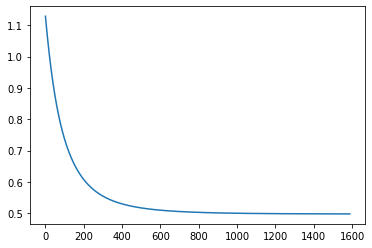

In [32]:
n_iter = n
plt.plot(np.arange(n_iter), c)
plt.show()

# Validation



> Scelta degli iperparametri


Nell'implementazione della logistic regression abbiamo visto alcuni parametri che il processo di apprendimento utilizza, ma non modifica.
Questi particolari parametri sono chiamati **iperparametri**.

*Come capire a quale valore impostarli in modo che l'algoritmo funzioni meglio?*

Non ci sono regole predefinite, solitamente si procede per test.
La fase di validazione, oltre per trovare il modello più performante sull'insieme di dati che abbiamo, serve anche a questo. 

Di seguito gli iperparametri che abbiamo visto nella logistic regression:



1.   **Learning Rate** "LR": fattore moltiplicativo che scala il gradiente e controlla la dimensione dello step.
    *   Se LR è troppo basso potrebbe essere dispendiosa la ricerca dell'ottimo -> convergenza lenta
    *   Se LR è troppo alto, potrebbe divergere oppure non arrivare mai all'ottimo, ma "saltarlo". 

2.   **Fattore Epsilon**: associamo all'iterazione t un costo C(t) e all'iterazione (t-1) un costo C(t-1). Il fattore epsilon garantisce che se (C(t)-C(t-1))< epsilon, allora l'algoritmo termina. In parole, quando la funzione di costo decresce da uno step al successivo di un valore infinitesimale, epsilon, significa che siamo arrivati (o quasi) all'ottimo.  



Vediamo i diversi comportamenti dell'algoritmo al variare degli iperparametri sopra citati attraverso il metodo **K-Fold Cross Validation**, di cui propongo una mia implementazione.

In [33]:
m = X_train.shape[0]
k = [5, 10]

def K_Fold_CV():
  random_idx = random.randint(0,1)
  K = int(k[random_idx])
  n_fold = int(m/K)
  dim_fold = int(m/n_fold)
  lr_list = []
  eps_list = []
  acc_list = []
  print("K =", K)
  print("Numero di folders =", n_fold)
  print("Dimensione di ciascun folder =", dim_fold) 
  print("\n")
  for i in range(K):
    lr = random.uniform(0.0001, 0.1)
    lr_list.append(lr)
    eps = random.uniform(0.000001, 0.0001)
    eps_list.append(eps)
    print("Validation sul folder numero "+str(i)+" Training sui restanti")
    print("Learning Rate: ", lr)
    print("Epsilon: ", eps)
    if i==0:                      # il val set è il primo folder
      start_valAt = 0
      end_valAt = dim_fold
      start_trainAt = dim_fold
      end_trainAt = m
      val_set = X_train[start_valAt:end_valAt]
      y_val = Y_train[start_valAt:end_valAt]
      train_set = X_train[start_trainAt:end_trainAt]
      y_train = Y_train[start_trainAt:end_trainAt]
    elif i<K-1:                   # il val set è in mezzo
      start_valAt = i*dim_fold
      end_valAt = start_valAt+dim_fold
      start_train1At = 0
      end_train1At = start_valAt
      start_train2At = end_valAt
      end_train2At = m
      val_set = X_train[start_valAt:end_valAt]
      y_val = Y_train[start_valAt:end_valAt]
      train_set = np.concatenate((X_train[start_train1At:end_train1At],X_train[start_train2At:end_train2At]))
      y = []
      for i in range(len(list(Y_train['Classification']))):
        if (i>=start_train1At and i<end_train1At) or (i>=start_train2At and i<end_train2At):
          y.append(list(Y_train['Classification'])[i])
      y_train = pd.DataFrame(data=y, columns=['Classification'])
      
    else:                          # il val set è alla fine
      start_valAt = i*dim_fold
      end_valAt = m
      start_trainAt = 0
      end_trainAt = start_valAt-1
      val_set = X_train[start_valAt:end_valAt]
      y_val = Y_train[start_valAt:end_valAt]
      train_set = X_train[start_trainAt:end_trainAt]
      y_train = Y_train[start_trainAt:end_trainAt]
    
    W = logistic_regression(train_set, y_train, lr, eps)[0]
    acc = test_logistic_regression(val_set, y_val, W)
    acc_list.append(acc*100)
    print("Accuracy ottenuta = "+str(acc*100)+"%\n")
  return acc_list, eps_list, lr_list

In [34]:
a, e, l = K_Fold_CV()
max_acc = max(a)
max_idx = a.index(max_acc)
print("Migliore accuracy ottenuta = "+str(max_acc)+"%, con LR = "+str(l[max_idx])+" e fattore epsilon =", e[max_idx])

K = 5
Numero di folders = 18
Dimensione di ciascun folder = 5


Validation sul folder numero 0 Training sui restanti
Learning Rate:  0.0355282712027009
Epsilon:  9.47962425625466e-05
Accuracy ottenuta = 80.0%

Validation sul folder numero 1 Training sui restanti
Learning Rate:  0.050439590534872895
Epsilon:  6.342125627136198e-05
Accuracy ottenuta = 80.0%

Validation sul folder numero 2 Training sui restanti
Learning Rate:  0.030173516776560428
Epsilon:  3.0833561659889975e-06
Accuracy ottenuta = 60.0%

Validation sul folder numero 3 Training sui restanti
Learning Rate:  0.08604427385943501
Epsilon:  9.740389111986943e-06
Accuracy ottenuta = 40.0%

Validation sul folder numero 4 Training sui restanti
Learning Rate:  0.09198803877833461
Epsilon:  3.1202171100082816e-05
Accuracy ottenuta = 54.166666666666664%

Migliore accuracy ottenuta = 80.0%, con LR = 0.0355282712027009 e fattore epsilon = 9.47962425625466e-05



> Confronto con altri modelli

Ora applichiamo nuovamente la K-Fold Cross Validation per vedere il modello che fornisce la migliore performance.
I classificatori testati sono Logistic Regression, SVM e Random Classifier.

In [35]:
m = X_train.shape[0]


def K_Fold_CV():
  K=10
  n_fold = int(m/K)
  dim_fold = int(m/n_fold)
  lr = LogisticRegression()
  clf_svm = svm.SVC()
  rf = RandomForestClassifier(n_estimators=100)
  models = [lr, clf_svm, rf]
  mdl_idx = 0
  results = {}
  print("K =", K)
  print("Numero di folders =", n_fold)
  print("Dimensione di ciascun folder =", dim_fold) 
  print("\n")
  for i in range(K):
    print("Validation sul folder numero "+str(i)+" Training sui restanti")
   
    if i==0:                      # il val set è il primo folder
      start_valAt = 0
      end_valAt = dim_fold
      start_trainAt = dim_fold
      end_trainAt = m
      val_set = X_train[start_valAt:end_valAt]
      y_val = Y_train[start_valAt:end_valAt]
      train_set = X_train[start_trainAt:end_trainAt]
      y_train = Y_train[start_trainAt:end_trainAt]
    elif i<K-1:                   # il val set è in mezzo
      start_valAt = i*dim_fold
      end_valAt = start_valAt+dim_fold
      start_train1At = 0
      end_train1At = start_valAt
      start_train2At = end_valAt
      end_train2At = m
      val_set = X_train[start_valAt:end_valAt]
      y_val = Y_train[start_valAt:end_valAt]
      train_set = np.concatenate((X_train[start_train1At:end_train1At],X_train[start_train2At:end_train2At]))
      y = []
      for i in range(len(list(Y_train['Classification']))):
        if (i>=start_train1At and i<end_train1At) or (i>=start_train2At and i<end_train2At):
          y.append(list(Y_train['Classification'])[i])
      y_train = pd.DataFrame(data=y, columns=['Classification'])
      
    else:                          # il val set è alla fine
      start_valAt = i*dim_fold
      end_valAt = m
      start_trainAt = 0
      end_trainAt = start_valAt-1
      val_set = X_train[start_valAt:end_valAt]
      y_val = Y_train[start_valAt:end_valAt]
      train_set = X_train[start_trainAt:end_trainAt]
      y_train = Y_train[start_trainAt:end_trainAt]
    
    models[mdl_idx].fit(train_set,y_train)
    train_score = models[mdl_idx].score(train_set, y_train)
    test_score = models[mdl_idx].score(val_set, y_val)
    if mdl_idx == 0:
      print("Con il modello di Logistic Regression ho: "+str(test_score)+" di accuracy\n")
      key = "Logistic Regression"
      old_value = 0
      new_value = test_score
      value = max(old_value, new_value)
      results[key]=value
    elif mdl_idx == 1:
      print("Con il modello SVM ho: "+str(test_score)+" di accuracy\n")
      key = "SVM"
      old_value = 0
      new_value = test_score
      value = max(old_value, new_value)
      results[key]=value
    elif mdl_idx == 2:
      print("Con il modello Random Classifier ho: "+str(test_score)+" di accuracy\n")
      key = "Random Classifier"
      old_value = 0
      new_value = test_score
      value = max(old_value, new_value)
      results[key]=value
    if mdl_idx < len(models)-1:
      mdl_idx += 1
    else:
      mdl_idx = 0
    
  return results

In [36]:
r = K_Fold_CV()

print("\nLe migliori performances ottenute con i diversi modelli sono: ", r)

K = 10
Numero di folders = 9
Dimensione di ciascun folder = 10


Validation sul folder numero 0 Training sui restanti
Con il modello di Logistic Regression ho: 0.9 di accuracy

Validation sul folder numero 1 Training sui restanti
Con il modello SVM ho: 0.4 di accuracy

Validation sul folder numero 2 Training sui restanti
Con il modello Random Classifier ho: 0.8 di accuracy

Validation sul folder numero 3 Training sui restanti
Con il modello di Logistic Regression ho: 0.8 di accuracy

Validation sul folder numero 4 Training sui restanti
Con il modello SVM ho: 0.5 di accuracy

Validation sul folder numero 5 Training sui restanti
Con il modello Random Classifier ho: 0.7 di accuracy

Validation sul folder numero 6 Training sui restanti
Con il modello di Logistic Regression ho: 0.5 di accuracy

Validation sul folder numero 7 Training sui restanti
Con il modello SVM ho: 0.8 di accuracy

Validation sul folder numero 8 Training sui restanti
Con il modello Random Classifier ho: 0.4 di accuracy


# Confronto con altri dataset

I risultati ottenuti precedentemente dipendono dal dataset scelto che, sebbene di largo utilizzo e di semplice lettura (si tratta di un referto medico da analisi del sangue), non risulta ben separabile linearmente. 

Esistono però, altri dataset che vengono utilizzati in questo campo.
Vediamo come, utilizzando un nuovo insieme di lavoro, cambiano i risultati.

Il dataset di interesse è contenuto nella libreria di sklearn e utilizza delle features estrapolate da esami FNA (Fine Needle Aspiration).

Di seguito riporto i passi, già commentati nella sezione precedente, per arrivare alla soluzione generata dalla Logistic Regression applicata su questo nuovo dataset.

In [37]:
from sklearn.datasets import load_breast_cancer

# importo dataset
dat = load_breast_cancer()

# riscrivo i dati  
li_target = [1 if x==0 else 0 for x in list(dat.target)]   # binary target 0 (B) or 1 (M) 
li_ftrs = list(dat.feature_names)                          # lista delle features 
df = pd.DataFrame(dat.data[:,:], columns=li_ftrs)
X = df
y = pd.Series(li_target)

# divido in train e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# preprocessamento dei dati con standardizzazione
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

# addestramento del modello con logistic regression
clf_lr = LogisticRegression(class_weight='balanced', dual=False, 
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          n_jobs=1, random_state=0, tol=0.0001, verbose=0, warm_start=False)

# test del modello 
lr = clf_lr.fit(X_train, y_train)
predictions = lr.predict(X_test)

# report di accuracy - precision - recall - f1 score
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.97      0.97      0.97        67
           1       0.96      0.96      0.96        47

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114



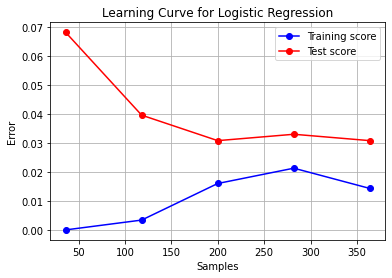

In [39]:
train_size, train_score, test_score = learning_curve(estimator=clf_lr, X=X_train, y=y_train, scoring = None )

train_loss_avg = 1 - np.mean(train_score, axis=1)
test_loss_avg = 1- np.mean(test_score, axis=1)

plt.plot(train_size, train_loss_avg, 'o-', color="b")
plt.plot(train_size, test_loss_avg, 'o-', color="r")
plt.title("Learning Curve for Logistic Regression")
plt.legend(('Training score', 'Test score'), loc='best')
plt.xlabel("Samples")
plt.ylabel("Error")
plt.grid()

plt.show()

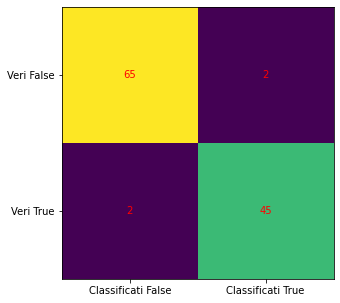

In [40]:
cm = confusion_matrix(y_test, predictions)
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Classificati False', 'Classificati True'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Veri False', 'Veri True'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

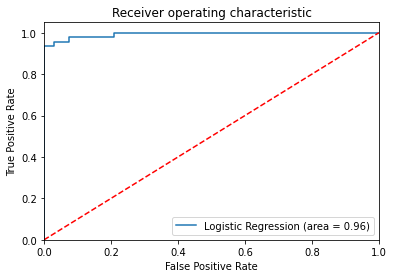

In [41]:
logit_roc_auc = roc_auc_score(y_test, predictions)
fpr, tpr, thresholds = roc_curve(y_test, clf_lr.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

I risultati ottenuti sono **notevolmente migliori**, anche senza ottimizzazione del modello (scelta degli iperparametri ottimi e tecniche di features selection) su questo nuovo dataset.

I fattori che hanno inciso maggiormente in questa differenza sono:

*   La **dimensione dei dataset**: il secondo è circa *cinque volte più grande* del primo. Ricordiamo che maggiore è la dimensione del dataset fornito alla macchina, migliore sarà l’accuratezza dei modelli risultanti.

*   La **qualità dei dataset**: come i dati sono distribuiti.





# Conclusioni

In questa sezione abbiamo visto in profondità il lavoro di un classificatore in ambito di apprendimento supervisionato che lavora in campo medico. 

Ma quali altri strumenti abbiamo per riuscire a capire se un paziente è affetto da questa malattia o no? Un metodo possibile è studiare le mammografie digitali. 

Analizziamo questo aspetto al link: https://colab.research.google.com/drive/1_QFWrBPMMVv74gnx5s8hujfUF_ssBnP9?usp=sharing 